# **Fake and Real - Political news Sentiment Analysis and Prediction with NLP**

With data retrieved from **[Kaggle](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?resource=download&select=real.csv)**, this jupyter performs NLP with two prediction methodologies.

During this **project** an exploratory analysis focused on **political news** is performed. Also, by **modeling the news' sentiment** we are able to predict whether a **political new** is likely to be **fake** or **real**, given its **title**.

- Politics only
- Balanced dataset

Possible explanation features:
- Citing
- Number of punctuation marks !?
- Proportion of CAPS out of all text

In [78]:
import pandas as pd                 # Data manipulation
import numpy as np                  # Numerical python
import matplotlib.pyplot as plt     # Visualization

from collections import defaultdict, Counter # collections manipulation
import re # Regular expressions
from wordcloud import WordCloud, STOPWORDS     # Text visualization

import os
from colorama import Fore, Back, Style  # Command color visualization

In [66]:
RANDOM_STATE = 11
HEAD = 5
STR_HEAD = 50

In [67]:
# Import the datasets
real_news = pd.read_csv('data/True.csv')
fake_news = pd.read_csv('data/Fake.csv')

In [68]:
# Get basic informattion for the real news
print(real_news.info(), '\n') # Print the news structure/info
print(real_news['subject'].unique(), '\n') # Print the unique subject of real news
real_news.head() # Print the news head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None 

['politicsNews' 'worldnews'] 



,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [69]:
# Get basic information for fake news
print(fake_news.info(), '\n') # Print the structure of the dataset
print(fake_news['subject'].unique(), '\n') # Print the unique subjects of the fake news
fake_news.head() # Print the head of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None 

['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east'] 



,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


As we can see, there is a difference of `subject` between the two datasets. This may affect the results...

In [70]:
# Add a label for identifying whether is a fake or real news
real_news['is_fake'] = 0 # Dummy label for real news
fake_news['is_fake'] = 1 # Dummy label for fake news

# Concatenate the datasets
news = pd.concat([real_news, fake_news]).reset_index().drop(columns='index')

news

,title,text,subject,date,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",1
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",1
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",1
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1


For the purpose of this analysis, only subjects explicitly labeled as `politics` will be take in account. Thus because 1) it was one easy-identifiable subject found both in the *real* and *false* dataset and 2) is thought that considering more categories that are not in both datasets, may bias the results.

In [71]:
politics_subject = ['politicsNews', 'politics'] # Create a list with the politics subjects
pnews = news.query('subject == @politics_subject') # Filter the news dataset by ONLY the 'politics' related subject
print(pnews['subject'].unique(), '\n') # Print the unique values, they MUST be 'politics'-related

# Print the size of the All-news dataset and the politics-only
print(f'All-News records: {news.shape[0]:,}')
print(f'Politics News records: {pnews.shape[0]:,}')
print(f'Politics News records as % All-News records: {pnews.shape[0] / news.shape[0]:.2%}\n')

print(pnews['is_fake'].value_counts()) # Get the distribution of fake and real news

pnews

['politicsNews' 'politics'] 

All-News records: 44,898
Politics News records: 18,113
Politics News records as % All-News records: 40.34%

0    11272
1     6841
Name: is_fake, dtype: int64


,title,text,subject,date,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
37303,APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...,The gay mafia has a new corporate Don. This i...,politics,"Mar 31, 2015",1
37304,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",politics,"Mar 31, 2015",1
37305,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,politics,"Mar 31, 2015",1
37306,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,"Mar 31, 2015",1


## **Pre-processing word Visualization**

Before we continue with **train-test split** and **processing** of the news. We will **visualize**  via **wordcloud** the words that appear within the **political news' titles**. And see beforehand if we watch up some patterns.

First, visualize the **fake political news**.

In [72]:
# We will create a string/text with ALL the fake titles from our sample.
# A brief lower-processing to avoid word-duplicates, with just upper cases as differences
fake_titles = " ".join(pnews.query("is_fake == 1").title.str.lower())

# Show the head of the result
fake_titles[:100]

'democrat senator warns mueller not to release findings on russia before 2018 midterms msnbc anchor f'

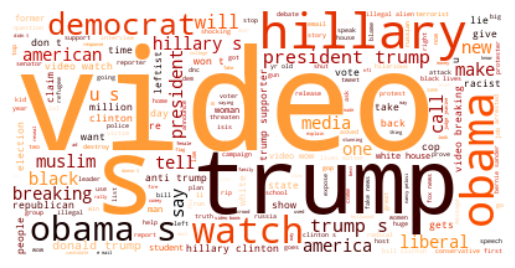

In [73]:
# Generate the wordcloud with the `fake_titles`` text
fake_titles_wc = WordCloud(stopwords=STOPWORDS, background_color='white', colormap='gist_heat', random_state=RANDOM_STATE).generate(fake_titles)

# Show the fake titles wordcloud
plt.imshow(fake_titles_wc, interpolation='bilinear')
_ = plt.axis('off')

**Secondly**, visualize the **real political news**.

In [74]:
# Create a string/text with the concatenation of ALL real news
real_titles = " ".join(pnews.query("is_fake == 0").title.str.lower())
# Show the head of `real_titles`
real_titles[:100]

'as u.s. budget fight looms, republicans flip their fiscal script u.s. military to accept transgender'

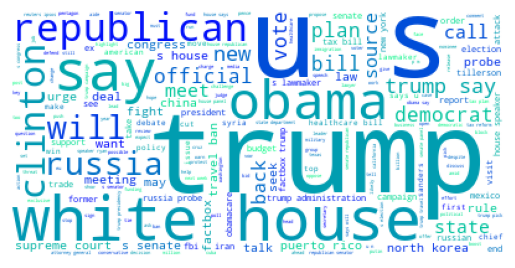

In [75]:
# Create the wordcloud with real titles
real_titles_wc = WordCloud(stopwords=STOPWORDS, background_color='white', colormap='winter', random_state=RANDOM_STATE).generate(real_titles)

# Show the wordcloud
plt.imshow(real_titles_wc)
_ = plt.axis('off')

So far, there are **few** major differences between the **fake** and **real** titles. One word that highlights in the **fake** wordcloud is **video**. Also one of the most visible differences are that, while in the **fake news wordcloud** words like **democrat** appear, while in the **real news**, **republican** does. Also, the term **white house** remarks within the **real news**.

Also, words that appear in both wordclouds are easily identifiable, particulaly, the words **trump**, **hillary**, **obama** appear as the most frequent tokens. This may be an issue at the moment of **classifiying**, because these words may be as equally probable to be **real** or **fake**. Thus, as a **recommendation** they should be taken **political STOPWORDS** for improving accuracy.

Now, which are the **words** that **ONLY** appear within the **fake** and **real** vocabulary? Let's check it out.

In [94]:
# Define a list of words/tokens for fake and real news, we do this by tokenizing using regular expressions
fake_titles_tokens = Counter(re.findall('\w+', fake_titles))
real_titles_tokens = Counter(re.findall('\w+', real_titles))

# Show an example of the result
print(f"{Fore.RED}{Style.BRIGHT} FAKE NEWS:{Style.RESET_ALL} {HEAD}-most common tokens: {fake_titles_tokens.most_common(HEAD)}", "red")
print(f"{Fore.GREEN}{Style.BRIGHT} REAL NEWS: {Style.RESET_ALL}{HEAD}-most common tokens:", real_titles_tokens.most_common(HEAD))

 FAKE NEWS: 5-most common tokens: [('video', 3355), ('to', 3011), ('s', 2435), ('trump', 2367), ('the', 1858)] red
 REAL NEWS: 5-most common tokens: [('trump', 5009), ('s', 4736), ('to', 4238), ('u', 3136), ('on', 2000)]


In [95]:
# Get the words that ONLY appear in the `fake_titles` set and NOT in `real_titles` set.
fake_titles_only = set(fake_titles_tokens).difference(set(real_titles_tokens))
list(fake_titles_only)[:HEAD]

['brutalized', 'instigate', 'coordination', 'tarmac', 'cnnleaks']

## **TO DO**:
Get the set difference and intersection of the **fake** and real news.
Visualize a summary with the two above images and the later ones.

## **Train-test split**

As seen above, the politics news represent 40% of the total news. Also, it is visible that the current politics dataset is unbalanced, being the *real* news almost the double of *fake* ones. For simplification purposes, the dataset for the final analysis will be balanced.

We will also define a train and test set for model evaluation.

In [7]:
# 5472 records represent ~ 80% of fake news
pnews_tt = pnews.query('is_fake == 0').sample(5472, random_state=22) # real train news
pnews_ft = pnews.query('is_fake == 1').sample(5472, random_state=22) # Fake train news
pnews_train = pd.concat([pnews_tt, pnews_ft]) # Concat the train set

print(pnews_train.shape, '\n') # Print the shape of the balanced-train dataset
print(pnews_train['is_fake'].value_counts())    # Print the distribution of the `is_fake` variable

pnews

(10944, 5) 

0    5472
1    5472
Name: is_fake, dtype: int64


,title,text,subject,date,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
37303,APPLE’S CEO SAYS RELIGIOUS FREEDOM LAWS ARE ‘D...,The gay mafia has a new corporate Don. This i...,politics,"Mar 31, 2015",1
37304,WATCH DIRTY HARRY REID ON HIS LIE ABOUT ROMNEY...,"In case you missed it Sen. Harry Reid (R-NV), ...",politics,"Mar 31, 2015",1
37305,OH NO! GUESS WHO FUNDED THE SHRINE TO TED KENNEDY,Nothing like political cronyism to make your s...,politics,"Mar 31, 2015",1
37306,BENGHAZI PANEL CALLS HILLARY TO TESTIFY UNDER ...,Does anyone really think Hillary Clinton will ...,politics,"Mar 31, 2015",1


In [8]:
# Define a test set

# Get the fake news sample
fake_test_ix = np.setdiff1d(pnews.query('is_fake == 1').index, pnews_ft.index) # Get the indexes difference (find those that are not within the train set)
pnews_ftest = pnews.loc[fake_test_ix]


# Get the real news sample
real_test_ix = np.setdiff1d(pnews.query('is_fake == 0').index, pnews_tt.index) # Get the indexes difference (find those that are not within the train set)
pnews_ttest = pnews.loc[real_test_ix].sample(fake_test_ix.size, random_state=22)

# Concat the test samples into the test set
pnews_test = pd.concat([pnews_ftest, pnews_ttest])

print(pnews_test.shape, '\n') # Print the size of the test set
print(pnews_test['is_fake'].value_counts(), '\n') # Print the distribution of fake vs. real news

pnews_test.head()

(2738, 5) 

1    1369
0    1369
Name: is_fake, dtype: int64 



,title,text,subject,date,is_fake
30473,GOTCHA! A Stammering John Podesta Stunned by a...,John Podesta is Hillary Clinton s former campa...,politics,18-Feb-18,1
30476,BUSTED! Maxine Waters’ Ties to Black Nationali...,We reported that Maxine Waters and members of ...,politics,18-Feb-18,1
30482,“THE TRUMP CURSE IS REAL”…Social Media Respond...,Two months before the Winter Olympics in Seoul...,politics,17-Feb-18,1
30488,TUCKER CARLSON Rips The Left On Gun Control Hy...,Tucker Carlson weighed in on the hysteria over...,politics,16-Feb-18,1
30493,TWO HIGH SCHOOL JROTC Members Tell INCREDIBLE ...,ABC News When two Marjory Stoneman Douglas Hi...,politics,15-Feb-18,1


<a name='1'></a>
## 1 - Process the Data

For any machine learning project, once you've gathered the data, the first step is to process it to make useful inputs to your model.
- **Remove noise / stopwords**: You will first want to remove noise from your data -- that is, remove words that don't tell you much about the content. These include all common words like 'I, you, are, is, etc...' that would not give us enough information on the sentiment.
- We'll also remove stock market tickers, retweet symbols, hyperlinks, and hashtags because they can not tell you a lot of information on the sentiment.
- You also want to remove all the punctuation from a tweet. The reason for doing this is because we want to treat words with or without the punctuation as the same word, instead of treating "happy", "happy?", "happy!", "happy," and "happy." as different words.
- Finally you want to use stemming to only keep track of one variation of each word. In other words, we'll treat "motivation", "motivated", and "motivate" similarly by grouping them within the same stem of "motiv-".

We have given you the function `process_tweet` that does this for you.

In [9]:
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import re

# Found issues

- Abbreviations such as **CBS** will be lost during the string process.
- ASCII emojies like `:)`, `:(` will be lost udirng the string process.

In [96]:
def process_string(s, nomenclature=True):
    """
    Process a string by eliminating stopwords, tokenizing and stemming the words.

    # Arguments
    s: str
        A string to be processed.

    # Return
    clean_tokens: list
        A list with clean tokens.
    """

    clean_tokens = [] # Set an empty list for cleaned tokens

    # Validate if we want to validate first the existence of nomenclature
    if nomenclature:
        nom_regex = '(?:[A-Z]\.){1,}'               # A regex for identifying nomenclature like 'U.S.'
        nom_regex_find = re.findall(nom_regex, s)   # Find all the occurences for the nomeclature regex
        if len(nom_regex_find) > 0:                 # Validate that there is at least one result within the find
            clean_tokens += nom_regex_find          # Append the found nomenclatures into the clean_tokens list
            s = re.sub(nom_regex, '', s)            # Replace the found nomeclanture with empty spaces, wont be considered for tokenizing

    non_word_regex = '[^\w]'                                # Create a regex for identifying non-words, e.g. '!', '’', '.' ...
    s_words_only = re.sub(non_word_regex, ' ', s.lower())   # Replace non-word symbols with an empty space

    stemmer = PorterStemmer()                       # Init a Porter stemmer, gets the root/stem of the words
    en_stopwords = stopwords.words('english')       # Store the english stopwords, they are not as relevant in a sentiment 
    tokens = word_tokenize(s_words_only)            # Create a list with tokens, using the nltk.word_tokenize

    # Create a list of clean tokens by stemming each word
    # if the word is not within the unwanted words. (e.g. stopwords/punctuation)
    clean_tokens += [
        stemmer.stem(word) for word in tokens
        if word not in en_stopwords
        if not re.match(non_word_regex, word)
    ]

    return clean_tokens

In [11]:
def build_freqs(strings, sentiments):
    """
    Build frequencies of tokens/words given its sentiment.
    
    strings: list
        A list of strings/sentences.
    sentiments: list
        A list with the sentiment of the strings/sentences.
    """

    # Start with an empty dictionary and populate it with the the pairs of combinations (word, sentiment).
    freqs = {}

    # Iterate over each string and its sentiment
    for s, sentiment in zip(strings, sentiments):
        clean_tokens = process_string(s) # Process the string and get its clean tokens
        for word in clean_tokens:
            pair = (word, sentiment)    # Create a a tuple with the `item` and its `sentiment`
            if pair in freqs.keys():    # Identify whether or not the pair is within the keys
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [12]:
# Get the freqs from the political news dataset
freqs = build_freqs(pnews_test.title, pnews_test.is_fake)
# Get the TOP 10 words with more frequency
list({k:v for k,v in sorted(freqs.items(), key=lambda item: item[1], reverse=real)}.items())[:10]

[(('video', 1), 697),
 (('trump', 0), 626),
 (('trump', 1), 491),
 (('U.S.', 0), 380),
 (('say', 0), 208),
 (('hillari', 1), 197),
 (('obama', 1), 186),
 (('hous', 0), 177),
 (('senat', 0), 150),
 (('republican', 0), 120)]

In [13]:
# Get the Vocabulary of the dataset (set of unique words)
V = list(set([pair[0] for pair in freqs.keys()]))
print(f"Vocabulary's length: {len(V):,}") # Print the Vocabulary's length, count of unique words within our news title dataset
V[:5] # Print the head of the Vocabulary

Vocabulary's length: 4,719


['cabl', 'world', 'profil', 'redistribut', 'bernardino']

In [15]:
# Get the top 50 words for each of the classes (fake and NON-fake ones)
fake50 = {pair:count for pair, count in sorted(freqs.items(), key=lambda item: item[1], reverse=real) if pair[1] == 1} # Get only the items that have a is_fake == 1
list(fake50.items())[:5] # Get the head of the fake_50

[(('video', 1), 697),
 (('trump', 1), 491),
 (('hillari', 1), 197),
 (('obama', 1), 186),
 (('clinton', 1), 107)]

In [16]:
# Get the top 50 words for non-fake title news
non_fake50 = {pair:count for pair, count in sorted(freqs.items(), key=lambda item: item[1], reverse=real) if pair[1] == 0}
list(non_fake50.items())[:5] # Get the head of non-fake

[(('trump', 0), 626),
 (('U.S.', 0), 380),
 (('say', 0), 208),
 (('hous', 0), 177),
 (('senat', 0), 150)]

Now get a dictionary with the word as key and frequency as value. (Without the tuple word-class as key)

In [21]:
# Get only the frequency of the words
fake50_freq = {item[0]:freq for item, freq in fake50.items()}
list(fake50_freq.items())[:5]

[('video', 697),
 ('trump', 491),
 ('hillari', 197),
 ('obama', 186),
 ('clinton', 107)]

In [22]:
# Get only the frequency of the words for NON_fake news
non_fake50_freq = {item[0]:freq for item, freq in non_fake50.items()}
list(non_fake50_freq.items())[:5]

[('trump', 626), ('U.S.', 380), ('say', 208), ('hous', 177), ('senat', 150)]

## **Wordcloud Visualization**